In [3]:
import pandas as pd
import os
import warnings
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from datetime import datetime
from datetime import date

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### ========================================================

In [4]:
test_0909_uni_test = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                'equipment_dict','fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 'vendor', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']
test_0909_uni_0909 = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                 'Комплектация','fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'price']

### ========================================================

In [5]:
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)
df= pd.read_csv('./Project_7_data/' + 'auto_ru_2020_09_09.csv',low_memory=False)

In [6]:
df_full= pd.read_csv('./Preproject_7_data/' + 'all_auto_ru_09_09_2020.csv',low_memory=False)

### ===================0909=================================

In [7]:
def bodyType_unification(x):
    res=[]
    x = x.lower() if type(x) == str else x  # <================
    try:
        for body_type in test.bodyType.unique():
            if body_type in x:
                res.append(body_type)
    except Exception: return x
    if not res: 
        return x.split()[0]
    return max(res)

def engineDisplacement_unification(x):
    x = float(re.sub("[^\d.]", r'', x)) if re.sub("[^\d.]", r'', x) else 0
    if x >= 7: x = 0
    return x

def train_options(x):
    point = "'available_options': "
    start = x.find(point)+len(point)+2
    finish = x.find("]",start) - 1
    return x[start:finish].split("', '")

def test_ownership_unification(x):
    try:
        digits = re.findall('\d+',x) 
        if len(digits) == 2: res = int(digits[0])*12 + int(digits[1])
        elif len(digits) == 1 and 'месяц' in x: res = int(digits[0])
        elif len(digits) == 1 and 'месяц' not in x: res = int(digits[0])*12
    except Exception: res = 0   
    return res

def train_ownership_unification(x):
    tmp = json.loads(x.replace("'",'"'))  if x==x else {'year': 2020, 'month': 9}
    res = (2020 - tmp['year'])*12 + tmp['month'] - 9
    if res<0: res = 0
    return res


In [8]:
def test_unification(df_to_proc):
    test = df_to_proc.copy()[test_0909_uni_test]
    owner_dict = {'3 или более': 3., '2\xa0владельца': 2.,'1\xa0владелец': 1.}
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: int(x[:-4]))
    # equipment_dict
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    # Владельцы
    test.Владельцы = test.Владельцы.map(owner_dict)
    # Владение
    test.Владение = test.Владение.apply(test_ownership_unification)
    return test

In [9]:
def train_0909_unification(df_to_proc):
    df = df_to_proc.copy()[test_0909_uni_0909]
    color_codes = {'040001': 'чёрный','FAFBFB': 'белый', '0000CC': 'синий', 
                   '200204': 'коричневый', 'EE1D19': 'красный', 'CACECB': 'серый',
                   'C49648': 'бежевый', '97948F': 'серебристый', 'FFD600': 'жёлтый',
                   'FF8649': 'оранжевый', '22A0F8': 'голубой','FFC0CB': 'розовый', 
                   'DEA522': 'золотистый', '007F00': 'зелёный', '660099': 'пурпурный',
                   '4A2197': 'фиолетовый'}
    transmission_dict = {'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 
                         'ROBOT':'роботизированная','VARIATOR':'вариатор'}
    vendor_dict = {'AUDI':'EUROPEAN','BMW':'EUROPEAN','HONDA':'JAPANESE','INFINITI':'JAPANESE',
                   'LEXUS':'JAPANESE','MERCEDES':'EUROPEAN','MITSUBISHI':'JAPANESE',
                   'NISSAN':'JAPANESE','SKODA':'EUROPEAN','TOYOTA':'JAPANESE',
                   'VOLKSWAGEN':'EUROPEAN','VOLVO':'EUROPEAN'}
    PTS_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
    wheel_dict = {'LEFT':'Левый', 'RIGHT':'Правый'}
    # bodyType
    df.dropna(subset=['bodyType'],inplace=True)
    df.bodyType = df.bodyType.apply(bodyType_unification)
    # color
    df.color = df.color.map(color_codes)
    # engineDisplacement
    df.engineDisplacement = df.engineDisplacement.apply(engineDisplacement_unification)
    # enginePower
    df.enginePower = df.enginePower.astype(int)
    # equipment_dict
    df['equipment_dict'] = df.Комплектация.apply(train_options)
    df.drop(columns=['Комплектация'],inplace=True)
    # modelDate 
    df.modelDate = df.modelDate.astype(int)
    # model_name
    df['model_name'] = df.model
    df.drop(columns=['model'],inplace=True)
    # numberOfDoors
    df.numberOfDoors = df.numberOfDoors.astype(int)
    # vehicleTransmission
    df.vehicleTransmission = df.vehicleTransmission.map(transmission_dict)
    # vendor
    df['vendor'] = df.brand.map(vendor_dict)
    # Владение
    df.Владение = df.Владение.apply(train_ownership_unification)
    # ПТС
    df.ПТС = df.ПТС.map(PTS_dict)
    # Руль
    df.Руль = df.Руль.map(wheel_dict)
    
    return df

In [10]:
%%time 
test_uni = test_unification(test)
train_0909_uni = train_0909_unification(df)
train_0909_full_uni = train_0909_unification(df_full)

Wall time: 4min 32s


## =================PARS===========================

In [11]:
pars = pd.read_csv('./Project_7_data/train_new.csv')
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)

In [12]:
test_pars_uni = ['model_name', 'equipment_dict', 'brand', 'modelDate', 
                 'productionDate', 'ПТС','mileage', 'car_url', 'engineDisplacement', 
                 'numberOfDoors', 'enginePower', 'vendor', 'color', 'vehicleTransmission', 
                 'sell_id', 'Владельцы', 'Руль', 'bodyType', 'Привод']

In [13]:
def test_pars_uniifcation(df_to_proc):
    test = df_to_proc.copy()[test_pars_uni] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN)
    # modelDate
    test.modelDate = test.modelDate.astype(float)
    # productionDate
    test.productionDate = test.productionDate.astype(float)
    # numberOfDoors
    test.numberOfDoors = test.numberOfDoors.astype(float)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    test.Владельцы = test.Владельцы.map(owner_dict)
    # mileage
    test.mileage = test.mileage.astype(float) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: float(x[:-4]))
    # equipment_dic
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    
    return test

In [14]:
def pars_unification(df_to_proc):
    pars = df_to_proc.copy()[test_pars_uni] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # modelDate
    model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
    model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
             model_generation_year.generation_year))
#     pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year) 
    pars.modelDate = pd.Series(
        [x+' '+y if x==x else x for x,y in zip(pars.modelDate,pars.bodyType)]).\
        map(model_generation_year)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    pars.Владельцы = test.Владельцы.map(owner_dict)
    # equipment_dic
    pars.equipment_dict = pars.equipment_dict[:50].apply(
        lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
        if x==x else x)    
    
    return pars

In [15]:
# pars_unification(pars)[:2]

In [16]:
# test_pars_uniifcation(test)[:2]

# =============ПРОПУСКИ=================

In [55]:
def missing_distribution():
    plt.figure(figsize=(14,3))
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 1]).plot.hist(
        bins=100,density=True,alpha = 0.5)
    plt.figure(figsize=(14,3))
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 2]).plot.hist(
        bins=100,density=True,alpha = 0.5)
    plt.figure(figsize=(14,3))
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
    log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 3]).plot.hist(
        bins=100,density=True,alpha = 0.5)

# Оработка пропусков
Займеся пропусками в приведенных к единому виду test и train
## Пропуски в train
Сначала посмотирм на количество прпусков в колонках:

In [56]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

Владельцы    13569
ПТС            361
vendor       39867
dtype: int64

In [57]:
train_0909_uni.isna().sum()[train_0909_uni.isna().sum()>0]

Владельцы    10970
ПТС            262
price          208
dtype: int64

Во первых обратим внимание на пропуски в `price` - наблюдения с пропуском в целевой переменной нам не нужны поэтому удаляем их.

In [58]:
train_0909_full_uni.dropna(subset=['price'],inplace=True)

In [59]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

Владельцы    13569
ПТС            361
vendor       39867
dtype: int64

Большая часть пропусков в колонках `vendor` и `Владельцы` , относительно небольшой количесвто пропусков `ПТС`. Рассмотрим каждую колонку отдельно.

### Владельцы

In [60]:
train_0909_full_uni.Владельцы.value_counts(dropna=False)

3.0    36098
2.0    20902
1.0    18398
NaN    13569
Name: Владельцы, dtype: int64

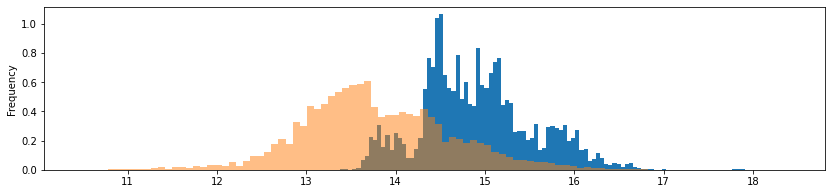

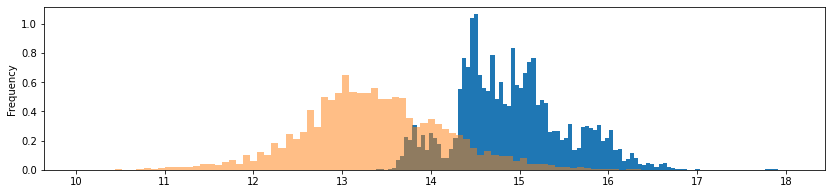

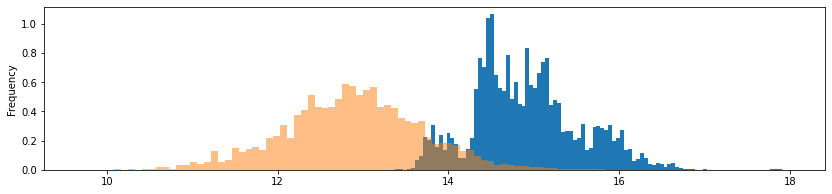

In [61]:
missing_distribution()

Ночего пхожего. Применим для заполнеия пропусков предсказание модели, обученой на нашм датасете, с целевой переменной  - `Владельцы`. В качестве моденли возьмем catboost с дефолтными параметрами. В качестве обучающей выьорки возьмем те признки из даатасета, котроый можно применить без сложной обрабтки.

In [62]:
train_0909_full_uni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88967 entries, 0 to 89377
Data columns (total 20 columns):
bodyType               88967 non-null object
brand                  88967 non-null object
color                  88967 non-null object
engineDisplacement     88967 non-null float64
enginePower            88967 non-null int32
fuelType               88967 non-null object
mileage                88967 non-null int64
modelDate              88967 non-null int32
numberOfDoors          88967 non-null int32
productionDate         88967 non-null int64
vehicleTransmission    88967 non-null object
Владельцы              75398 non-null float64
Владение               88967 non-null int64
ПТС                    88606 non-null object
Привод                 88967 non-null object
Руль                   88967 non-null object
price                  88967 non-null float64
equipment_dict         88967 non-null object
model_name             88967 non-null object
vendor                 49100 non-null o

In [34]:
train_0909_full_uni.brand[train_0909_full_uni.vendor.isna()].unique()

array(['CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG'], dtype=object)

In [40]:
test_uni.isna().sum()[test_uni.isna().sum()>0]

engineDisplacement    55
ПТС                    1
dtype: int64

### vendor

### ПТС

## ===================EDA========================

## ==============BASELINE EXTENSE===============

# ПОДВАЛ

In [64]:
ticket_url = 'https://auto.ru/moskva/cars/toyota/land_cruiser_prado/used/'
brand = 'TOYOTA'

# brand = features['brand']
model_name_start = ticket_url.find(brand.lower()) + len(brand) + 1
model_name_end = ticket_url.find('/',model_name_start)
ticket_url[model_name_start:model_name_end].upper()

#### car_url

print(test.car_url[5]),print(pars.car_url[5]);

#### engineDisplacement

test.engineDisplacement.apply(
    lambda x: float(x[:-4]) if x[:-4] else np.NaN).unique()

pars.engineDisplacement.unique()

#### vehicleTransmission

test.vehicleTransmission.unique() ,pars.vehicleTransmission.unique()

#### Руль

test.Руль.unique(),pars.Руль.unique()

#### sell_id

test.sell_id[0],pars.sell_id[0]

#### modelDate

test.modelDate = test.modelDate.astype(float)
test.modelDate.unique()

model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
         model_generation_year.generation_year))
pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year)

pars.modelDate.unique()

#### color

set(pars.color.unique()) - set(test.color.unique())

#### Привод

test.Привод.unique(),pars.Привод.unique()

#### productionDate

test.productionDate = test.productionDate.astype(float)
test.productionDate[:5]

pars.productionDate[:5]

#### numberOfDoors

test.numberOfDoors = test.numberOfDoors.astype(float)
test.numberOfDoors.unique()

pars.numberOfDoors.unique()

#### vendor

test.vendor.unique(), pars.vendor.unique()

#### Владельцы

owner_dict = {
    '3 или более': 3., 
    '2\xa0владельца': 2.,
    '1\xa0владелец': 1.
}
test.Владельцы = test.Владельцы.map(owner_dict)
pars.Владельцы = pars.Владельцы.map(owner_dict)

test.Владельцы.unique(), pars.Владельцы.unique()

#### mileage

test.mileage = test.mileage.astype(float)
test.mileage.unique()

pars.mileage.unique()

#### enginePower

test.enginePower.isna().sum()

test.enginePower = test.enginePower.apply(lambda x: int(x[:-4])).astype(float)
test.enginePower.unique()

pars.enginePower.unique()[:5]

#### model_name

test.model_name.unique()[:30]

pars.model_name.unique()[:5]

#### ПТС

test.ПТС.unique(), pars.ПТС.unique()

#### bodyType

set(test.bodyType.unique()) - set(pars.bodyType.unique())

#### equipment_dict

test.equipment_dict = test.equipment_dict.apply(lambda x: list(json.loads(x).keys()) if x==x else [])

pars.equipment_dict = pars.equipment_dict[:50].apply(
    lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
    if x==x else x)



test.equipment_dict[0][:2],pars.equipment_dict[0][:2]

#### 'description'

test.description[0]

# pars.description[0]

#### brand

test.brand.unique()

pars.brand.unique()

#### offerprice

pars.offerprice

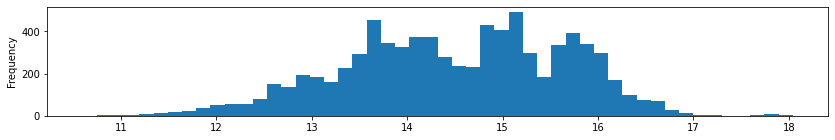

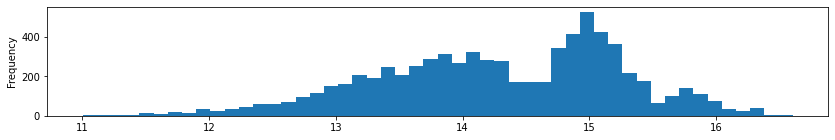

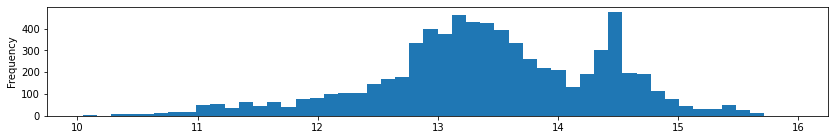

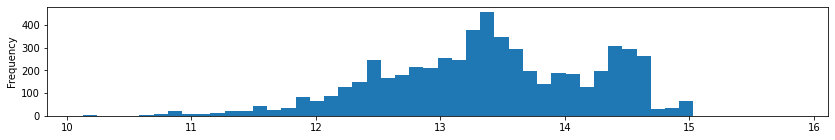

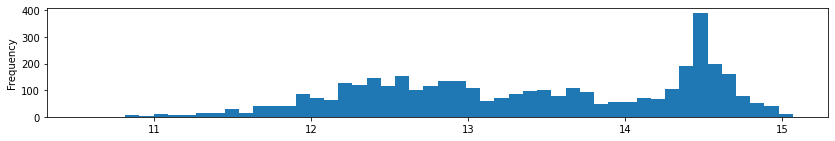

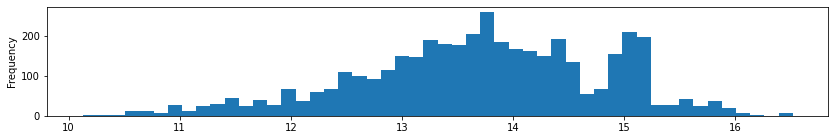

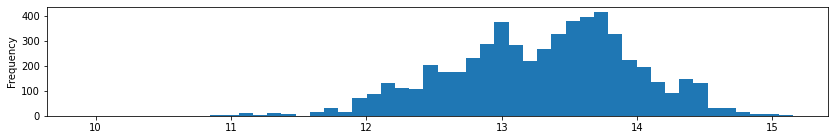

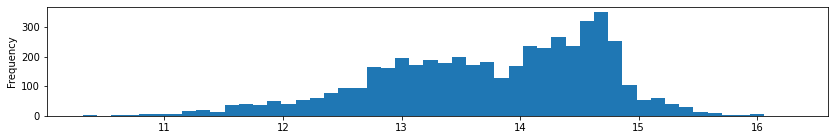

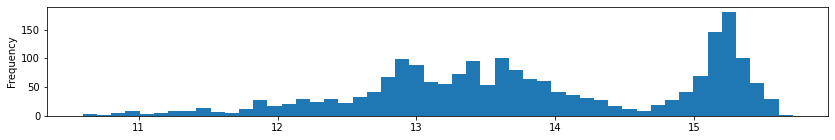

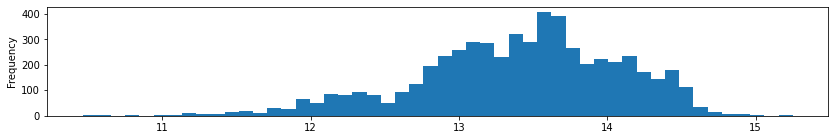

In [52]:
# brands_with_missing = train_0909_full_uni[train_0909_full_uni.Владельцы.isna()].brand.unique()
brands_with_missing = train_0909_full_uni[train_0909_full_uni.Владельцы.isna()].brand.value_counts().index[:10]

for brand in brands_with_missing:
    plt.figure(figsize=(14,2))
    log(train_0909_full_uni.price[train_0909_full_uni.brand == brand]).plot.hist(bins=50)